In [30]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.datasets import imdb
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM,Bidirectional
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing import sequence
import datetime
import io
import itertools
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split

import sys
import os
# Obtener la ruta del directorio actual
current_dir = os.getcwd()

# Construir la ruta relativa al directorio que quieres agregar
relative_dir = os.path.join(current_dir, 'mis_pkgs/')

# Agregar la ruta relativa al sys.path
sys.path.insert(0, relative_dir)

from MIOPATIA_db import DB_management as db 


Voy a quedarme con los 62 atunes con su última medida

In [31]:
filename = "hdf_28_06_atunes_agilent_clasificados_ampliado_the_best6.hdf"
with pd.HDFStore(filename,complib="zlib",complevel=4) as hdf_db:
    pre_p_e1  = hdf_db.get('data/pollos_estado')
    pre_p_e1 = pre_p_e1.loc[pre_p_e1['Pollo'] != 0]
    # p_e =pre_p_e1.drop_duplicates(subset = ['Pollo', 'Medida'],  keep = 'last').reset_index(drop = True)
    t    = hdf_db.get('data/tabla')
    X_train=np.zeros((pre_p_e1.shape[0],401,8))
    y_train=np.zeros((pre_p_e1.shape[0],1))
    x=0
    for index, row in pre_p_e1.iterrows():   # El primer registro no se toma en cuenta porque es basura
        Primero = int(row['Primero'])
        Ultimo  = int(row['Ultimo'])
        estado  = int(row['Estado'])
        print(Primero)
        print(Ultimo)
        print(estado)
        if estado == 0 or estado== 1:
            target = 1
        else:
            target = 0
        pepito=np.array(t.iloc[Primero:Ultimo+1])
        # #print(pepito.shape)
        X_train[x]=pepito[:,3:11]
        print(X_train[x][0:4,:])       
        y_train[x]=target
        x=x+1


print(X_train.shape)
print(y_train.shape)
#print(X_train[0:4,:,:])

0
400
0
[[ 2.11548583e+05 -2.41023444e-01  4.48948241e+03  1.82646509e+04
   1.88083206e+04 -1.32977288e+00  2.05433600e+05 -5.04959300e+04]
 [ 2.00995358e+05  1.91218305e-01 -3.66824953e+03  1.89491848e+04
   1.93009756e+04 -1.76201463e+00  1.97331900e+05  3.82002000e+04]
 [ 1.55641236e+05 -8.40308325e-01  1.81014739e+04  1.62152414e+04
   2.43022101e+04 -7.30488002e-01  1.03849000e+05 -1.15929200e+05]
 [ 2.05898070e+05  5.33430353e-02 -9.54981716e+02  1.78856667e+04
   1.79111436e+04 -1.62413936e+00  2.05605200e+05  1.09780200e+04]]
401
801
0
[[ 2.11548583e+05 -2.41023444e-01  4.48948241e+03  1.82646509e+04
   1.88083206e+04 -1.32977288e+00  2.05433600e+05 -5.04959300e+04]
 [ 2.00995358e+05  1.91218305e-01 -3.66824953e+03  1.89491848e+04
   1.93009756e+04 -1.76201463e+00  1.97331900e+05  3.82002000e+04]
 [ 1.55641236e+05 -8.40308325e-01  1.81014739e+04  1.62152414e+04
   2.43022101e+04 -7.30488002e-01  1.03849000e+05 -1.15929200e+05]
 [ 2.05898070e+05  5.33430353e-02 -9.54981716e+02 

In [32]:
#print(X_train[1][0:4][:])

In [33]:
#print(y_train[1:20])

Aqui filtrariamos si hay filas que no nos interesan. En este caso dejo pasar todos los casos

In [34]:
# print(p_e)
# # X_train_filtrado = X_train[2:][:,:]
# # y_train_filtrado = y_train[2:]
X_train_filtrado = X_train
y_train_filtrado = y_train

# print(X_train_filtrado.shape)
# print(y_train_filtrado.shape)
# print(X_train_filtrado[0][:,:])

Vamos a normalizar o escalar los datos

In [35]:
scaler = MinMaxScaler(feature_range=(0, 1))
data_2d = X_train_filtrado.reshape(-1, X_train_filtrado.shape[-1])
normalized_data_2d = scaler.fit_transform(data_2d)
X_train_Normalizado=normalized_data_2d.reshape(X_train_filtrado.shape)
y_train_Normalizado=y_train_filtrado # los valores ya estaban normalizados
print(X_train_Normalizado[0])

[[1.99062329e-01 4.54191925e-01 5.41285390e-02 ... 5.45808075e-01
  1.93782044e-01 5.62451904e-01]
 [1.89061733e-01 6.18265517e-01 3.05538651e-02 ... 3.81734483e-01
  1.86109492e-01 6.30893149e-01]
 [1.46082620e-01 2.26710839e-01 9.34652400e-02 ... 7.73289161e-01
  9.75784006e-02 5.11961150e-01]
 ...
 [1.08332633e-02 5.11105047e-03 4.11916304e-02 ... 9.94888950e-01
  1.01853216e-03 5.91555463e-01]
 [1.05712449e-02 5.89689000e-03 4.11914830e-02 ... 9.94103110e-01
  1.00477181e-03 5.91769500e-01]
 [1.01917432e-02 7.33906006e-03 4.11917161e-02 ... 9.92660940e-01
  9.92103396e-04 5.92080493e-01]]


Vamos a hacer los conjuntos de entrenamiento validacion y test

In [36]:
# Divide el dataset en entrenamiento y temporal (test+validación)
X_temp, X_test_def, y_temp, y_test_def = train_test_split(X_train_Normalizado, y_train_Normalizado, test_size=0.2, stratify=y_train_Normalizado, random_state=42)

# Divide el dataset temporal en validación y test
X_train_def, X_val_def, y_train_def, y_val_def = train_test_split(X_temp, y_temp, test_size=0.25, stratify=y_temp, random_state=42)

# Ahora, X_train, X_val y X_test contienen los datos de entrada para los conjuntos de entrenamiento, validación y prueba, respectivamente.
# y_train, y_val y y_test contienen las clases correspondientes.

In [37]:
print(X_train_def.shape)
print(X_val_def.shape)
print(X_test_def.shape)
print(y_train_def.shape)
print(y_val_def.shape)
print(y_test_def.shape)

(1860, 401, 8)
(621, 401, 8)
(621, 401, 8)
(1860, 1)
(621, 1)
(621, 1)


In [38]:
%load_ext tensorboard

# %tensorboard --logdir logs
#log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
#tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [39]:
def plot_to_image(figure):
    """
    Converts the matplotlib plot specified by 'figure' to a PNG image and
    returns it. The supplied figure is closed and inaccessible after this call.
    """
    
    buf = io.BytesIO()
    
    # Use plt.savefig to save the plot to a PNG in memory.
    plt.savefig(buf, format='png')
    
    # Closing the figure prevents it from being displayed directly inside
    # the notebook.
    plt.close(figure)
    buf.seek(0)
    
    # Use tf.image.decode_png to convert the PNG buffer
    # to a TF image. Make sure you use 4 channels.
    image = tf.image.decode_png(buf.getvalue(), channels=4)
    
    # Use tf.expand_dims to add the batch dimension
    image = tf.expand_dims(image, 0)
    
    return image

In [40]:
def plot_confusion_matrix(cm, class_names):
    """
    Returns a matplotlib figure containing the plotted confusion matrix.
    
    Args:
       cm (array, shape = [n, n]): a confusion matrix of integer classes
       class_names (array, shape = [n]): String names of the integer classes
    """
    
    figure = plt.figure(figsize=(8, 8))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title("Confusion matrix")
    plt.colorbar()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)
    
    # Normalize the confusion matrix.
    cm = np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], decimals=2)
    
    # Use white text if squares are dark; otherwise black.
    threshold = cm.max() / 2.
    threshold = 0.5
    
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        color = "red" if cm[i, j] > threshold else "black"
        plt.text(j, i, cm[i, j], horizontalalignment="center", color=color)
        
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    return figure

In [41]:
algoritmo='RMSprop'
supermax=8*4
lossfunction='binary_crossentropy'
factor_aprendizaje=0.001
dimension_LSTM=50
dimension_dense=50
model = Sequential()
model.add(Bidirectional(LSTM(dimension_LSTM, return_sequences=True),input_shape=(401, 8)))
#model.add(Bidirectional(LSTM(50, return_sequences=True)))
#model.add(Bidirectional(LSTM(50, return_sequences=True)))
#model.add(Bidirectional(LSTM(50, return_sequences=False)))
model.add(Dense(dimension_dense, activation='tanh'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='lossfunction', optimizer=algoritmo, metrics=['accuracy'])
model.optimizer.lr=(factor_aprendizaje)
print(model.summary())

experimento="LSTM_{}_densebipolar_{}_loss_{}_lr_{}_algoritmo_{}".format(dimension_LSTM,dimension_dense,lossfunction,factor_aprendizaje,algoritmo)
logdir="./logs/defs/{}_{}".format(experimento,datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback=tf.keras.callbacks.TensorBoard(log_dir=logdir, histogram_freq=1)
file_writer_cm = tf.summary.create_file_writer(logdir + '/cm')


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_1 (Bidirecti  (None, 401, 100)          23600     
 onal)                                                           
                                                                 
 dense_2 (Dense)             (None, 401, 50)           5050      
                                                                 
 dense_3 (Dense)             (None, 401, 1)            51        
                                                                 
Total params: 28701 (112.11 KB)
Trainable params: 28701 (112.11 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [42]:
class_names=["Normal","Anormal"]

In [43]:
def log_confusion_matrix(epoch, logs):
    
    # Use the model to predict the values from the test_images.
    y_pred = model.predict(X_test_def)
    y_pred2=np.round(y_pred[:,-1]).astype(int)
    #y_pred2=np.where(y_pred>0,1,0)
    #y_pred2=y_pred2[:,-1]
    y_test_def2=y_test_def  
    #y_test_def2=np.where(y_test_def>0,1,0)
    cm=confusion_matrix(y_test_def2, y_pred2)
    # disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    figura = plot_confusion_matrix(cm, class_names=class_names)
    cm_image = plot_to_image(figura)
    
    # Log the confusion matrix as an image summary.
    with file_writer_cm.as_default():
        tf.summary.image("Confusion Matrix", cm_image, step=epoch)

In [44]:
cm_callback = tf.keras.callbacks.LambdaCallback(on_epoch_end=log_confusion_matrix)

In [45]:
early_stop=tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=500, verbose=2, mode='auto', baseline=None, restore_best_weights=True)
model.fit(X_train_Normalizado, y_train_Normalizado, epochs=2000, batch_size=20, callbacks=[tensorboard_callback, cm_callback, early_stop], validation_data=(X_val_def, y_val_def))
# Final evaluation of the model
scores = model.evaluate(X_test_def, y_test_def, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Epoch 1/2000
156/156 [==============================] - 15s 76ms/step - loss: 0.9656 - accuracy: 0.0048 - val_loss: 0.9783 - val_accuracy: 0.0000e+00
Epoch 2/2000
156/156 [==============================] - 9s 61ms/step - loss: 0.9587 - accuracy: 0.0000e+00 - val_loss: 1.0061 - val_accuracy: 0.1021
Epoch 3/2000
156/156 [==============================] - 10s 61ms/step - loss: 0.9545 - accuracy: 0.0011 - val_loss: 0.9560 - val_accuracy: 0.0000e+00
Epoch 4/2000
156/156 [==============================] - 10s 61ms/step - loss: 0.9534 - accuracy: 0.0000e+00 - val_loss: 0.9572 - val_accuracy: 0.0000e+00
Epoch 5/2000
156/156 [==============================] - 9s 61ms/step - loss: 0.9537 - accuracy: 0.0000e+00 - val_loss: 0.9552 - val_accuracy: 0.0000e+00
Epoch 6/2000
156/156 [==============================] - 10s 61ms/step - loss: 0.9549 - accuracy: 0.0000e+00 - val_loss: 0.9542 - val_accuracy: 0.0000e+00
Epoch 7/2000
156/156 [==============================] - 10s 61ms/step - loss: 0.9531 - acc

In [46]:
y_pred = model.predict(X_test_def)
#y_pred2=np.round(y_pred[:,-1]).astype(int)
y_pred2=np.where(y_pred>0,1,0)
y_pred2=y_pred2[:,-1]
y_test_def2=np.where(y_test_def>0,1,0)
print(y_pred.shape)
print(y_pred2.shape)
print(y_test_def2.shape)
#print(y_test_def[25])

20/20 [==============================] - 0s 21ms/step
(621, 401, 1)
(621, 1)
(621, 1)


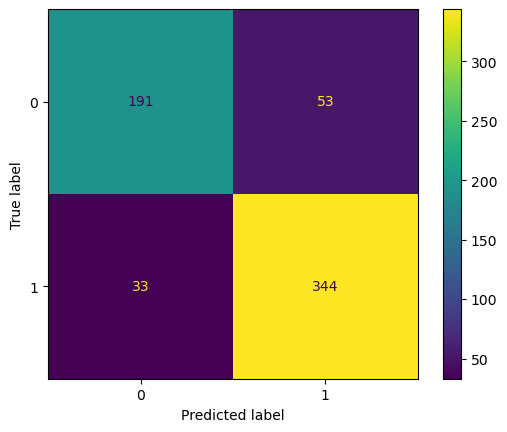

In [47]:
#docs_infra: no_execute

cm=confusion_matrix(y_test_def2, y_pred2)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

In [48]:
# model.save('modelos/modelote1203_200')  # creates a HDF5 file 'my_model.h5'

In [49]:
model.save('modelos/modelo_perfecto_{}_{}'.format(experimento,datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))) 

INFO:tensorflow:Assets written to: modelos/modelo_perfecto_LSTM_50_densebipolar_50_augmentation_32_lr_0.001_algoritmo_RMSprop_20240315-143818/assets


INFO:tensorflow:Assets written to: modelos/modelo_perfecto_LSTM_50_densebipolar_50_augmentation_32_lr_0.001_algoritmo_RMSprop_20240315-143818/assets
